In [1]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from pyspark.pandas import read_csv
import pyspark.pandas as ps
from pyspark import SparkContext, SparkConf
# means is for items, df is for collab

In [2]:
sc = SparkContext.getOrCreate()
sc.setCheckpointDir('/alscp')
sc.getConf().getAll()

[('spark.driver.host', 'host.docker.internal'),
 ('spark.driver.port', '49263'),
 ('spark.executor.memory', '10g'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.memory', '20g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.startTime', '1637646121775'),
 ('spark.app.id', 'local-1637646122540'),
 ('spark.ui.showConsoleProgress', 'true')]

In [3]:
ps.set_option('compute.default_index_type', 'distributed')
path ='data\collab\collab_filter.csv'
df = read_csv(path)

In [4]:
df.head()

,streamerId,userId,interactionTime
0,641416,86,1.000000
1,3050449,94,14.921875
2,2469,98,1.000000
3,3045251,99,5.125000
4,3045744,110,1.000000


In [5]:
ratings = df.to_spark()

In [6]:
ratings.show()

+----------+------+------------------+
|streamerId|userId|   interactionTime|
+----------+------+------------------+
|    641416|    86|               1.0|
|   3050449|    94|         14.921875|
|      2469|    98|               1.0|
|   3045251|    99|             5.125|
|   3045744|   110|               1.0|
|   2856504|   124|3.6354166666666665|
|   3051730|   175|           4.78125|
|   1897415|   184|               1.0|
|   1227172|   184|               1.0|
|   3036965|   213|               1.0|
|   2886534|   218|          7.703125|
|   3014795|   222|           4.09375|
|    534407|   240| 4.830357142857143|
|      6948|   240|           2.03125|
|   3038730|   257|               1.0|
|   2911377|   266|           4.09375|
|   2993536|   290|               1.0|
|   3050222|   331|           2.71875|
|   3045440|   366|               1.0|
|   3050772|   371|               1.0|
+----------+------+------------------+
only showing top 20 rows



In [7]:
(training, test) = ratings.randomSplit([0.8,0.2], 38)

In [8]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
mapping = {'item_id':'streamerId','rating': 'interactionTime', 'user_id': 'userId'}

In [12]:
from bayes_opt import BayesianOptimization
pbounds = {'regParam': (0.001,1),
            'rank': (1,30)}
def findOptimalModel(regParam=0.3, rank=10):
    rank = int(rank)
    als = ALS(maxIter=40, regParam=regParam, rank=rank, nonnegative=True,
              userCol=mapping['user_id'], itemCol=mapping["item_id"], ratingCol=mapping["rating"], coldStartStrategy='drop')
    lrModel = als.fit(training)
    predictions = lrModel.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol=mapping["rating"],
                                    predictionCol="prediction")
    rmse = evaluator.evaluate(predictions) 
    return -1 *rmse # bayes opt maximizes function

def trainOptimalModel(regParam=0.3, rank=10):
    rank = int(rank)
    als = ALS(maxIter=40, regParam=regParam, rank=rank, nonnegative=True,
              userCol=mapping['user_id'], itemCol=mapping["item_id"], ratingCol=mapping["rating"], coldStartStrategy='NaN')
    lrModel = als.fit(training)
    return lrModel

In [13]:
optimizer = BayesianOptimization(
    f=findOptimalModel,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1
)

optimizer.probe( # default values for als
    params={'regParam': .001,
            'rank': 10.0},
    lazy=True,
)


In [14]:
optimizer.maximize(
    init_points=10,
    n_iter=5
)

|   iter    |  target   |   rank    | regParam  |
-------------------------------------------------
|  1        | -9.119    |  10.0     |  0.001    |
|  2        | -3.175    |  13.09    |  0.7206   |
|  3        | -3.165    |  1.003    |  0.303    |
|  4        | -3.695    |  5.256    |  0.09325  |
|  5        | -3.305    |  6.402    |  0.3462   |
|  6        | -3.191    |  12.51    |  0.5393   |
|  7        | -3.176    |  13.16    |  0.6855   |
|  8        | -3.196    |  6.929    |  0.8782   |
|  9        | -3.148    |  1.794    |  0.6708   |
|  10       | -3.188    |  13.1     |  0.5591   |
|  11       | -3.452    |  5.071    |  0.1989   |
|  12       | -3.202    |  16.88    |  1.0      |
|  13       | -7.503    |  20.16    |  0.001    |
|  14       | -3.199    |  30.0     |  1.0      |
|  15       | -6.467    |  27.12    |  0.001    |
|  16       | -8.651    |  15.42    |  0.001    |


In [15]:
optimizer.max

{'target': -3.1478518599577314,
 'params': {'rank': 1.7942402027398587, 'regParam': 0.6707970426682238}}

In [16]:
import matplotlib.pyplot as plt
rmses=[]
iterations= []
for i, res in enumerate(optimizer.res):
    iterations.append(i)
    rmses.append(-1 * res['target'])


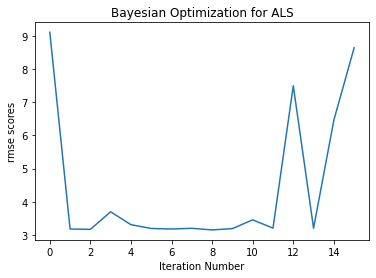

In [17]:
plt.plot(iterations, rmses)
plt.ylabel('rmse scores')
plt.xlabel('Iteration Number')
plt.title('Bayesian Optimization for ALS')
plt.show()

In [ ]:
model = trainOptimalModel(**optimizer.max['params'])

In [ ]:
predictions = model.transform(test) # NEED TO CONVERT NANS TO SOMETHING USEFUL!!!!!!!!!!!!!
evaluator = RegressionEvaluator(metricName="rmse", labelCol=mapping["rating"],
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions.dropna())
print("Root-mean-square error = " + str(rmse))

# Save the model
model.write().overwrite().save("models/als_explicit_collab")
print("Model successfully saved")

In [ ]:
predictions.show() # NEED TO CONVERT NANS TO SOMETHING USEFUL!!!!!!!!!!!!!

In [ ]:
# test if model can be loaded
kmeans = ALSModel.load("models/als_explicit_collab")

In [ ]:
predictions = kmeans.transform(ratings) # predict on everything

In [ ]:
predictions.show()

In [ ]:
predictions.coalesce(1).write.format('csv').mode("overwrite").option('header', 'true').save('data/collab_predictions')